# (SWAG-approximated) Bayesian Neural Network

In [205]:
import jax
import distrax
import optax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from typing import Callable
from tqdm.notebook import tqdm
from functools import partial
from sklearn.metrics import confusion_matrix
from torchvision.datasets import MNIST
from jax.flatten_util import ravel_pytree

In [173]:
from tqdm.notebook import tqdm

In [26]:
%config InlineBackend.figure_format = "retina"

In [ ]:
root = "/tmp/mnist"
mnist_train = MNIST(root, download=True, train=True)
mnist_test = MNIST(root, download=True, train=False)

In [275]:
class MLP1D(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.relu(nn.Dense(10)(x))
        x = nn.relu(nn.Dense(10)(x))
        x = nn.relu(nn.Dense(10)(x))
        x = nn.Dense(10)(x)
        return x

    
class LeNet5(nn.Module):
  num_classes: int
  activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
    
  @nn.compact
  def __call__(self, x):
    x = x if len(x.shape) > 1 else x[None, :]
    x = x.reshape((x.shape[0], 28, 28, 1))
    x = self.activation(nn.Conv(features=6, kernel_size=(5,5), padding="SAME")(x))
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
    x = self.activation(nn.Conv(features=16, kernel_size=(5,5), padding="VALID")(x))
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
    x = x.reshape((x.shape[0], -1))
    x = self.activation(nn.Dense(features=120)(x))
    x = self.activation(nn.Dense(features=84)(x))
    x = nn.Dense(features=self.num_classes)(x)
    x = nn.log_softmax(x)
    return x

class SmallCNN(nn.Module):
    num_classes: int
    activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=6, kernel_size=(5, 5), padding="SAME")(x)
        x = self.activation(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=120)(x)
        x = self.activation(x)
        x = nn.Dense(features=84)(x)
        x = self.activation(x)
        x = nn.Dense(features=self.num_classes)(x)
        x = nn.log_softmax(x)
        return x
        

def bnn_log_joint(params, X, y, model):
    flatten_params, _ = ravel_pytree(params)
    logits = model.apply(params, X)
    
    log_prior = distrax.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    log_likelihood = distrax.Multinomial(10, logits=logits).log_prob(y).sum()
    
    log_joint = log_prior + log_likelihood
    return log_joint

def bnn_loss_fn(params, X, y, model): return -bnn_log_joint(params, X, y, model)

In [268]:
key = jax.random.PRNGKey(314)
key_samples, key_init, key_train, key = jax.random.split(key, 4)

In [278]:
X_train = jnp.array(mnist_train.data)
y_train = jnp.array(mnist_train.targets)

n_train, *_ = X_train.shape
# "Gaussanised" MNIST
Xf_train = X_train[..., None]
Xf_train = Xf_train / Xf_train.max()
Xf_train = (Xf_train - Xf_train.mean()) / Xf_train.std()

y_ohe_train = jax.nn.one_hot(y_train, 10)

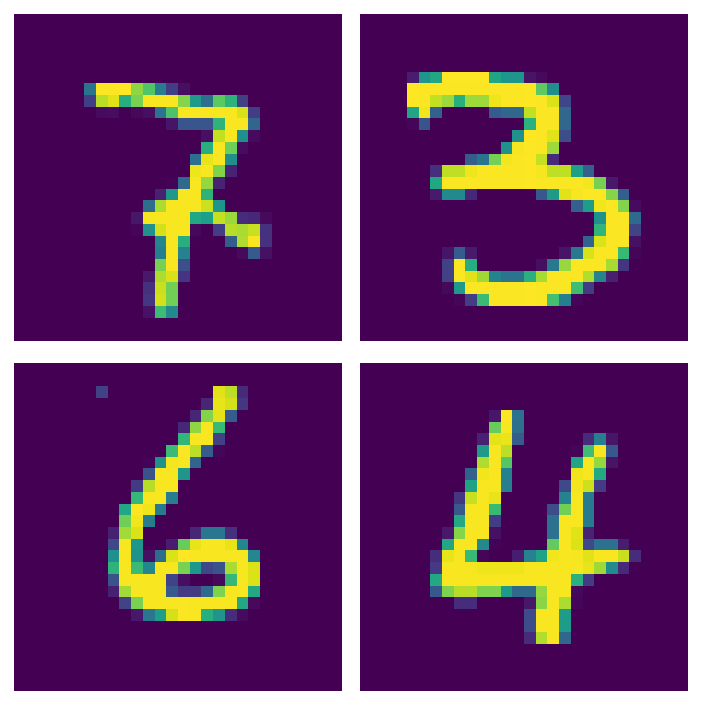

In [270]:
key = jax.random.PRNGKey(314)
key_sample, key = jax.random.split(key)
ixs = jax.random.choice(key, n_train, (4,))

fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.ravel()
for ix, ax in zip(ixs, axs):
    ax.imshow(Xf_train[ix].reshape(28, 28))
    ax.axis("off")
plt.tight_layout()

In [271]:
def update_first_moment(moment, params, n):
    moment = jax.tree_map(lambda mean, theta: (n * mean + theta) / (n + 1),
                          moment, params)
    return moment


def update_second_moment(moment, params, n):
    moment = jax.tree_map(lambda mean2, theta: (n * mean2 + theta ** 2) / (n + 1),
                          moment, params)
    return moment

In [272]:
@jax.jit
def train_step(params, opt_state, X_batch, y_batch):
    loss_fn = partial(bnn_loss_fn, X=X_batch, y=y_batch, model=model)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params
    

def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch_sgd(key, params, opt_step, X, y, batch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    total_loss = 0
    num_batches = len(batch_ixs)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
        total_loss += loss
    
    mean_loss = total_loss / num_batches
    return params, opt_step, mean_loss

In [273]:
batch_size = 500
# X_batches = Xf_train.reshape(batch_size, -1, 28 ** 2)
# y_batches = y_ohe_train.reshape(batch_size, -1, 10)

In [279]:
batch_size = 2000
num_epochs = 150
learning_rate = 1e-3
tx = optax.adam(learning_rate=learning_rate)

model = SmallCNN(10)

batch = jnp.ones((batch_size, 28, 28, 1))
params = model.init(key_init, batch)
opt_state = tx.init(params)

losses = []

loss_old = jnp.inf
for e in tqdm(range(num_epochs)):
    _, key_train = jax.random.split(key_train)
    params, opt_state, loss = train_epoch_sgd(key_train, params, opt_state,
                                              Xf_train, y_ohe_train, batch_size, e)
    losses.append(loss)
    
    if abs(loss / loss_old - 1) < 5e-6:
        break
    else:
        loss_old = loss

  0%|          | 0/150 [00:00<?, ?it/s]

In [280]:
%%time
yhat_train = model.apply(params, Xf_train).argmax(axis=1)

CPU times: user 78 ms, sys: 5.92 ms, total: 83.9 ms
Wall time: 113 ms


In [281]:
acc_train = (y_train == yhat_train).mean()
print(f"{acc_train:0.2%}")
confusion_matrix(y_train, yhat_train)

98.96%


array([[5897,    0,    1,    1,    0,    2,   14,    0,    3,    5],
       [   1, 6700,    7,    0,    2,    1,    0,    7,   12,   12],
       [   4,    2, 5901,    4,    0,    2,    2,    4,   33,    6],
       [   0,    0,    4, 6006,    0,   78,    0,    2,   25,   16],
       [   1,    2,    1,    0, 5732,    1,   18,    1,    9,   77],
       [   1,    1,    1,    1,    0, 5406,    7,    0,    3,    1],
       [   1,    2,    0,    0,    0,   14, 5899,    0,    2,    0],
       [   2,   10,   15,    7,    3,    7,    0, 6107,   17,   97],
       [   2,    3,    1,    1,    1,   17,    3,    0, 5814,    9],
       [   6,    1,    0,    0,    5,   12,    0,    5,    8, 5912]])

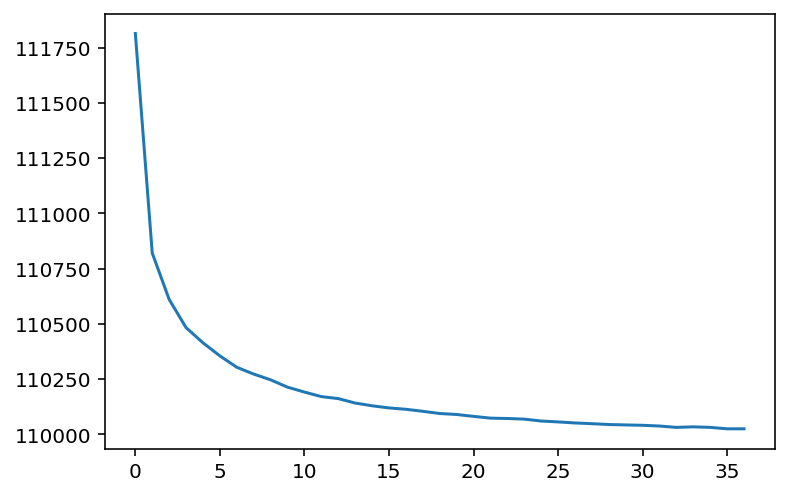

In [282]:
plt.plot(losses)